In [24]:
using MPI
using CLIMA
using Logging
using CLIMA.Mesh.Topologies
using CLIMA.Mesh.Grids
using CLIMA.DGmethods
using CLIMA.DGmethods.NumericalFluxes
using CLIMA.MPIStateArrays
using CLIMA.LowStorageRungeKuttaMethod
using LinearAlgebra
using CLIMA.GenericCallbacks: EveryXWallTimeSeconds, EveryXSimulationSteps
using CLIMA.ODESolvers
ENV["GKS_ENCODING"] = "utf-8"
using Plots
gr()

Plots.GRBackend()

In [25]:
include("soilmodel.jl")
MPI.Initialized() || MPI.Init()
mpicomm = MPI.COMM_WORLD

MPI.Comm(MPI.MPI_Comm(0x0000000128c96410))

In [30]:
# set up domain
topl = StackedBrickTopology(mpicomm, (0:1,0:-1:-10); periodicity = (true,false),boundary=((0,0),(1,2)))
grid = DiscontinuousSpectralElementGrid(topl, FloatType = Float64, DeviceArray = Array, polynomialorder = 5)

m = SoilModel(1.0,1.0,1.0,20.0,10.0)

# Set up DG scheme
dg = DGModel( # 
  m, # "PDE part"
  grid,
  CentralNumericalFluxNonDiffusive(), # penalty terms for discretizations
  CentralNumericalFluxDiffusive(),
  CentralGradPenalty())


Δ = min_node_distance(grid)
CFL_bound = (Δ^2 / (2m.λ/(m.ρ*m.c)))
dt = CFL_bound*0.001 # TODO: provide a "default" timestep based on  Δx,Δy,Δz

# state variable
Q = init_ode_state(dg, Float64(0))

# initialize ODE solver
lsrk = LSRK54CarpenterKennedy(dg, Q; dt = dt, t0 = 0)

dt

6.899875101735983e-6

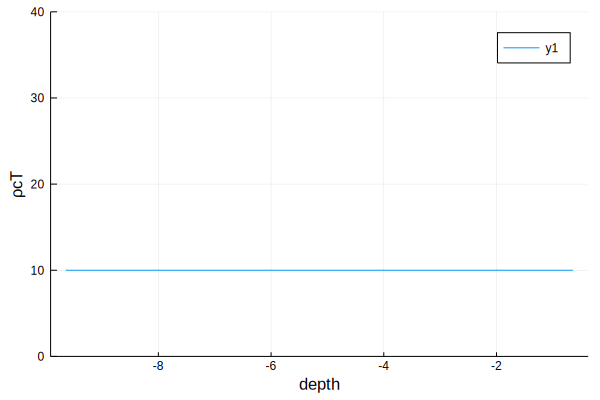

In [36]:
function plotstate(grid, Q)
    # TODO:
    # this currently uses some internals: provide a better way to do this
    Xg = reshape(grid.vgeo[(1:6).+3*6,CLIMA.Mesh.Grids.vgeoid.x2id,:],:)
    Yg = reshape(Q.data[(1:6).+3*6,1,:],:)
    plot(Xg, Yg, xlabel="depth", ylabel="ρcT", ylimit=(0,40))
end

plotstate(grid, Q)

In [ ]:
# run model
solve!(Q, lsrk; timeend=40000*dt)

In [ ]:
plotstate(grid, Q)